# Apply PCP to MVBS data

Here we use algorithms implemented by [ShunChi100](https://github.com/ShunChi100/RobustPCA/) to apply PCP (Principal Component Pursuit, or Robust Pricipal Component Analysis) to the MVBS data, and save the low-rank and sparse components into a netcdf file that will be easy to use and plot later.

## Load data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
MVBS_path = '../data/'
MVBS_file = '20150817-20151017_MVBS_time_Sv_rangeBin5_all_corrected.nc'

In [3]:
MVBS = xr.open_dataset(os.path.join(MVBS_path, MVBS_file))
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 ...
    range      (ping_time, range_bin) float64 ...

Reorder the frequency dimension:

In [4]:
MVBS = MVBS.reindex({'frequency': [38000,120000,200000]})

In [5]:
MVBS_vals = MVBS['MVBS'].values

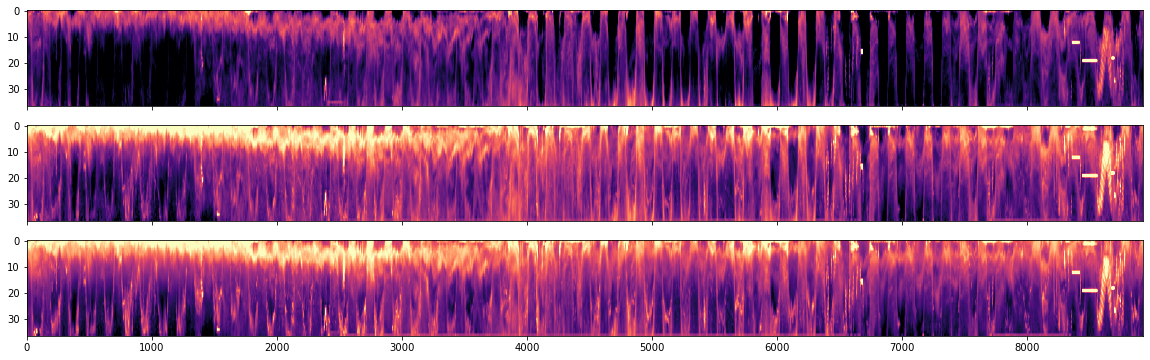

In [6]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(MVBS_vals[37:0:-1,:,iax],
                    aspect='auto',cmap='magma',vmin=-80,vmax=-50)

## Reshape matrix for decomposition

In [7]:
MVBS_vals.shape

(41, 8928, 3)

Given the dimension of `MVBS_vals`, we know that we need to reorder the dimensions and then reshape to get to the 2D matrix form we can use for PCP and sPCP decomposition.

We know our dataset has 3 frequencies, 41 range bins, 62 days, and 144 averaged ping bins with each day.

In [8]:
n_depth_pre = MVBS_vals.shape[0]
n_frequencies = MVBS_vals.shape[2]
n_ping_bins = 144
n_observations = int(MVBS_vals.shape[1]/n_ping_bins)

In [9]:
n_observations, n_frequencies, n_depth_pre, n_ping_bins

(62, 3, 41, 144)

In [10]:
MVBS_vals_reshape = np.moveaxis(MVBS_vals,[0,1,2],[1,2,0])\
                    .reshape(n_frequencies, n_depth_pre, n_observations, n_ping_bins)

In [11]:
MVBS_vals_reshape.shape

(3, 41, 62, 144)

Sanity check by plotting out the first day:

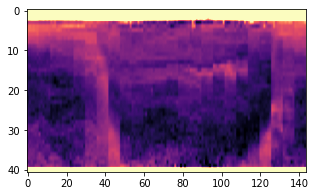

In [12]:
fig, ax = plt.subplots(1,1,figsize=(5,3),sharex=True)
im = plt.imshow(MVBS_vals_reshape[0,::-1,0,:],aspect='auto',cmap='magma',vmin=-80,vmax=-50)

We can see that the first bin near the transducer and the last 3 bins near the surface are contaminated by transducer ringing and strong surface reflection. We want to exclude them from the analysis. The shape we want to get to eventually is `(62, everything else)`, and the intermediate step (for convenience our future `reshape` operations) is `(62, 3, 144, 37)`, which requires some permuation of the dimensions.

In [13]:
# Test permutation
np.moveaxis(MVBS_vals_reshape[:,37:0:-1,:,:],[0,1,2],[1,2,0]).shape

(62, 3, 37, 144)

In [14]:
n_depth_bins = 37

In [15]:
# Reshape to fit what we need for PCP
MVBS_for_PCP = np.moveaxis(MVBS_vals_reshape[:,37:0:-1,:,:],[0,1,2],[1,2,0]).reshape([62,-1])
MVBS_for_PCP.shape

(62, 15984)

## PCP decomposition

In [16]:
from RobustPCA.rpca import RobustPCA

In [17]:
rpca = RobustPCA()

Default parameters for `rpca` are:
```python
lamb=None, 
mu=None, 
max_rank=None, 
tol=1e-6, 
max_iter=100, 
use_fbpca=False, 
fbpca_rank_ratio=0.2
```

These parameters are well-documented [in the code](https://github.com/ShunChi100/RobustPCA/blob/master/RobustPCA/rpca.py)

Here we first run the default parameters:

In [18]:
rpca.fit(MVBS_for_PCP)
L_rpca = rpca.get_low_rank()
S_rpca = rpca.get_sparse()

Not converged!
Total error: 15.456207, allowed tolerance: 0.000001


We can see that it has not convered, so we increase `max_iter` and run it again.

**NOTE: this will take some time to run!**

In [19]:
rpca = RobustPCA(max_iter=10000)
rpca.fit(MVBS_for_PCP)
L_rpca = rpca.get_low_rank()
S_rpca = rpca.get_sparse()

Converged!


In [20]:
# Sanity check for shape
L_rpca.shape, L_rpca.reshape(n_observations, n_frequencies, n_depth_bins, n_ping_bins).shape

((62, 15984), (62, 3, 37, 144))

Now we reshape the low-rank and sparse components back to arrays with meaningul dimensions.

In [21]:
L_rpca_reorg = L_rpca.reshape(n_observations, n_frequencies, n_depth_bins, n_ping_bins)
S_rpca_reorg = S_rpca.reshape(n_observations, n_frequencies, n_depth_bins, n_ping_bins)

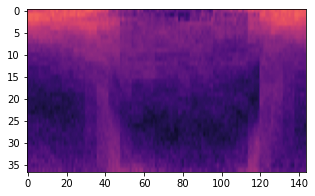

In [22]:
# Check day 1 again
fig, ax = plt.subplots(1,1,figsize=(5,3),sharex=True)
im = plt.imshow(L_rpca_reorg[0,0,:,:],aspect='auto',cmap='magma',vmin=-80,vmax=-50)

### Low-rank component

In [23]:
L_rpca_reorg.shape

(62, 3, 37, 144)

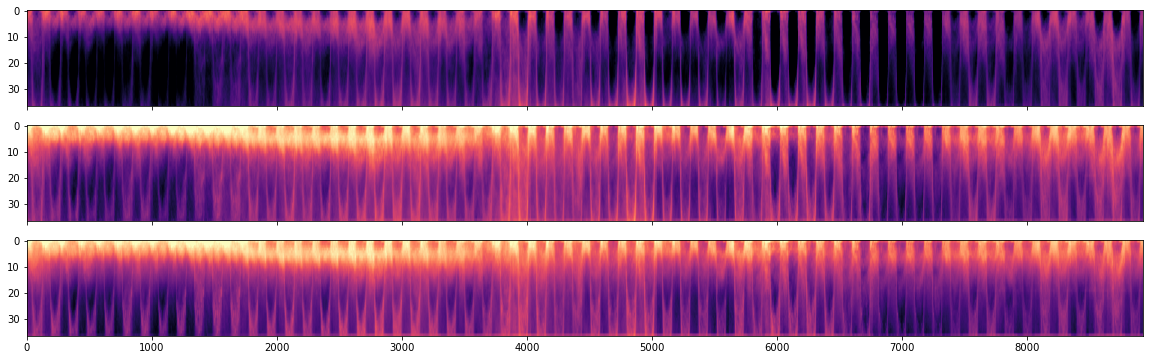

In [24]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(np.moveaxis(L_rpca_reorg[:,iax,:,:], [0,1], [1,0]).reshape(37,-1), 
                    aspect='auto',cmap='magma',vmin=-80,vmax=-50)

### Sparse component

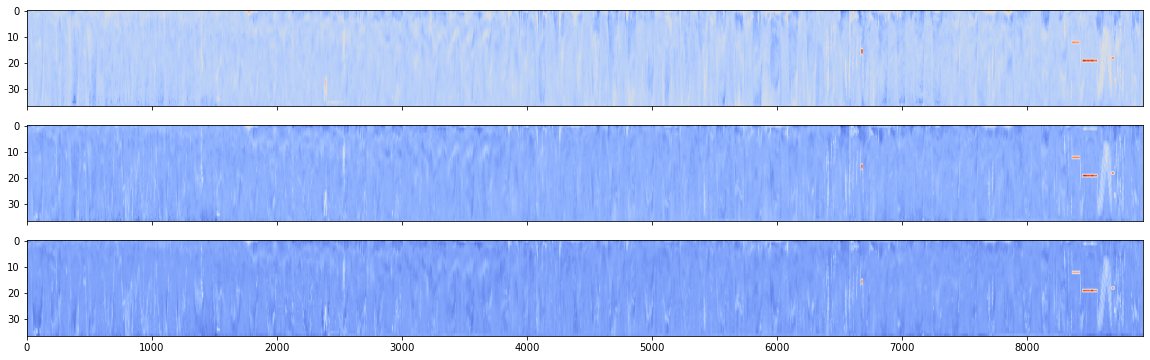

In [25]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
for iax, axx in enumerate(ax):
    im = axx.imshow(np.moveaxis(S_rpca_reorg[:,iax,:,:], [0,1], [1,0]).reshape(37,-1), 
                    aspect='auto',cmap='coolwarm')

## Save results as netCDF files

In [26]:
save_path = '../data/'
rpca_filename = os.path.splitext(MVBS_file)[0] + '_rpca.nc'

In [27]:
import pandas as pd

### Save PCP results

In [28]:
ds_rpca = xr.Dataset({'low_rank': (['date','frequency','depth','hour'], L_rpca_reorg),
                      'sparse': (['date','frequency','depth','hour'], S_rpca_reorg)
                     },
                     coords={'date': pd.date_range('2015-08-17', periods=62),
                             'frequency': MVBS['frequency'].values,
                             'depth': MVBS['range'].isel(ping_time=0).values[37:0:-1],
                             'hour': np.arange(0,24,24/144)
                            })

In [29]:
ds_rpca

<xarray.Dataset>
Dimensions:    (date: 62, depth: 37, frequency: 3, hour: 144)
Coordinates:
  * date       (date) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
  * frequency  (frequency) int64 38000 120000 200000
  * depth      (depth) float64 184.0 179.0 174.0 169.0 ... 14.91 9.943 4.972
  * hour       (hour) float64 0.0 0.1667 0.3333 0.5 ... 23.33 23.5 23.67 23.83
Data variables:
    low_rank   (date, frequency, depth, hour) float64 -62.81 -63.01 ... -69.12
    sparse     (date, frequency, depth, hour) float64 -2.91 -1.336 ... -8.556

Sanity check using the first day:

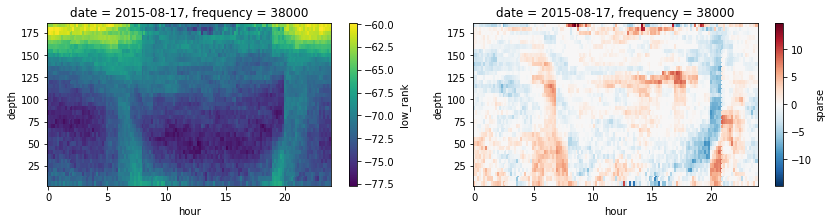

In [30]:
fig, ax = plt.subplots(1,2,figsize=(14,3))
ds_rpca['low_rank'].isel(frequency=0, date=0).plot(ax=ax[0])
ds_rpca['sparse'].isel(frequency=0, date=0).plot(ax=ax[1])
plt.show()

Save to file:

In [31]:
ds_rpca.to_netcdf(os.path.join(save_path, rpca_filename))

### Some checks

Below are some checks to make sure the coordinates get set correctly.

In [32]:
pd.date_range('2015-08-17', periods=62)

DatetimeIndex(['2015-08-17', '2015-08-18', '2015-08-19', '2015-08-20',
               '2015-08-21', '2015-08-22', '2015-08-23', '2015-08-24',
               '2015-08-25', '2015-08-26', '2015-08-27', '2015-08-28',
               '2015-08-29', '2015-08-30', '2015-08-31', '2015-09-01',
               '2015-09-02', '2015-09-03', '2015-09-04', '2015-09-05',
               '2015-09-06', '2015-09-07', '2015-09-08', '2015-09-09',
               '2015-09-10', '2015-09-11', '2015-09-12', '2015-09-13',
               '2015-09-14', '2015-09-15', '2015-09-16', '2015-09-17',
               '2015-09-18', '2015-09-19', '2015-09-20', '2015-09-21',
               '2015-09-22', '2015-09-23', '2015-09-24', '2015-09-25',
               '2015-09-26', '2015-09-27', '2015-09-28', '2015-09-29',
               '2015-09-30', '2015-10-01', '2015-10-02', '2015-10-03',
               '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07',
               '2015-10-08', '2015-10-09', '2015-10-10', '2015-10-11',
      

In [33]:
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * frequency  (frequency) int64 38000 120000 200000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 2.344 17.41 ... -52.79
    range      (ping_time, range_bin) float64 0.0 4.972 9.943 ... 193.9 198.9

Check `MVBS['range']` to construct depth vector:

In [34]:
MVBS['range'].isel(ping_time=0).values[37:0:-1]

array([183.95149565, 178.9798336 , 174.00817156, 169.03650951,
       164.06484747, 159.09318542, 154.12152338, 149.14986134,
       144.17819929, 139.20653725, 134.2348752 , 129.26321316,
       124.29155111, 119.31988907, 114.34822702, 109.37656498,
       104.40490294,  99.43324089,  94.46157885,  89.4899168 ,
        84.51825476,  79.54659271,  74.57493067,  69.60326862,
        64.63160658,  59.65994453,  54.68828249,  49.71662045,
        44.7449584 ,  39.77329636,  34.80163431,  29.82997227,
        24.85831022,  19.88664818,  14.91498613,   9.94332409,
         4.97166204])

In [35]:
MVBS['range'].isel(ping_time=0)

<xarray.DataArray 'range' (range_bin: 41)>
array([  0.        ,   4.97166204,   9.94332409,  14.91498613,
        19.88664818,  24.85831022,  29.82997227,  34.80163431,
        39.77329636,  44.7449584 ,  49.71662045,  54.68828249,
        59.65994453,  64.63160658,  69.60326862,  74.57493067,
        79.54659271,  84.51825476,  89.4899168 ,  94.46157885,
        99.43324089, 104.40490294, 109.37656498, 114.34822702,
       119.31988907, 124.29155111, 129.26321316, 134.2348752 ,
       139.20653725, 144.17819929, 149.14986134, 154.12152338,
       159.09318542, 164.06484747, 169.03650951, 174.00817156,
       178.9798336 , 183.95149565, 188.92315769, 193.89481974,
       198.86648178])
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
    ping_time  datetime64[ns] 2015-08-17